<a href="https://colab.research.google.com/github/prabhhav/JupyterNotebooks/blob/main/Prabhhav_Tf_Image_Classification_Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

This tutorial uses a dataset of about 3,700 photos of flowers. The dataset contains 5 sub-directories, one per class:

```
flower_photo/
  daisy/
  dandelion/
  roses/
  sunflowers/
  tulips/
```

In [ ]:
import pathlib
dataset_url = "https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz"
data_dir = tf.keras.utils.get_file('flower_photos', origin=dataset_url, untar=True)
data_dir = pathlib.Path(data_dir)

228818944/228813984 [==============================] - 1s 0us/step


In [ ]:
data_dir

PosixPath('/root/.keras/datasets/flower_photos')

In [ ]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3670


In [ ]:
list(data_dir.glob('*/*.jpg'))[0]

PosixPath('/root/.keras/datasets/flower_photos/daisy/3711723108_65247a3170.jpg')

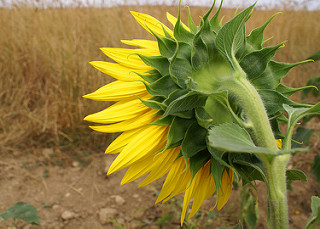

In [ ]:
PIL.Image.open(list(data_dir.glob('*/*.jpg'))[1000])

# Load using keras.preprocessing

Let's load these images off disk using the helpful [image_dataset_from_directory](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image_dataset_from_directory) utility. This will take you from a directory of images on disk to a `tf.data.Dataset` in just a couple lines of code. If you like, you can also write your own data loading code from scratch by visiting the [load images](https://www.tensorflow.org/tutorials/load_data/images) tutorial.

In [ ]:
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [ ]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    shuffle=True, 
    seed=123, 
    validation_split=0.2, 
    subset='training',
)

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir, 
    batch_size=BATCH_SIZE, 
    image_size=IMG_SIZE,
    shuffle=True, 
    seed=123, 
    validation_split=0.2, 
    subset='validation',
)

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train_ds.class_names
class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

## Visualize

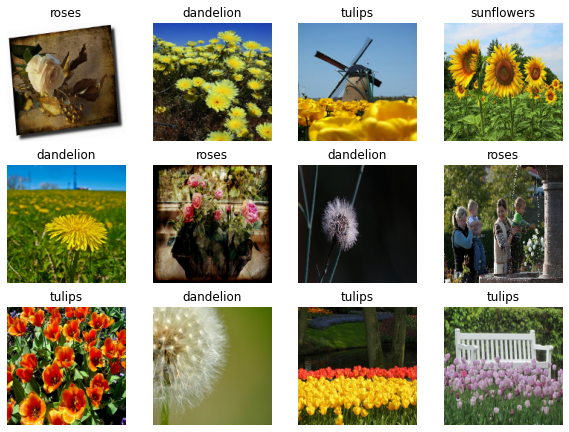

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(12):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
for i in range(4):
  for images, labels in train_ds.take(1):
    print(labels)
    print(len(labels))

tf.Tensor([3 3 4 4 1 3 4 3 4 4 1 3 0 0 2 4 1 3 1 1 1 3 1 2 1 3 4 1 4 4 4 3], shape=(32,), dtype=int32)
32
tf.Tensor([1 2 3 3 1 2 4 4 4 4 1 4 3 1 2 1 0 3 3 0 4 3 3 1 4 1 4 4 1 1 1 1], shape=(32,), dtype=int32)
32
tf.Tensor([0 1 2 1 0 3 3 1 1 0 3 3 1 1 3 2 4 4 0 1 4 4 2 2 2 1 0 0 2 1 1 1], shape=(32,), dtype=int32)
32
tf.Tensor([3 4 1 2 0 4 4 1 2 3 1 1 1 3 0 4 0 2 4 4 1 1 1 2 3 4 3 3 0 4 2 4], shape=(32,), dtype=int32)
32


In [ ]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 160, 160, 3)
(32,)


## Configure the dataset for performance

Let's make sure to use buffered prefetching so you can yield data from disk without having I/O become blocking. These are two important methods you should use when loading data.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch. This will ensure the dataset does not become a bottleneck while training your model. If your dataset is too large to fit into memory, you can also use this method to create a performant on-disk cache.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training. 

Interested readers can learn more about both methods, as well as how to cache data to disk in the [data performance guide](https://www.tensorflow.org/guide/data_performance#prefetching).

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_da = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

## Data Augmentation

In [ ]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
])

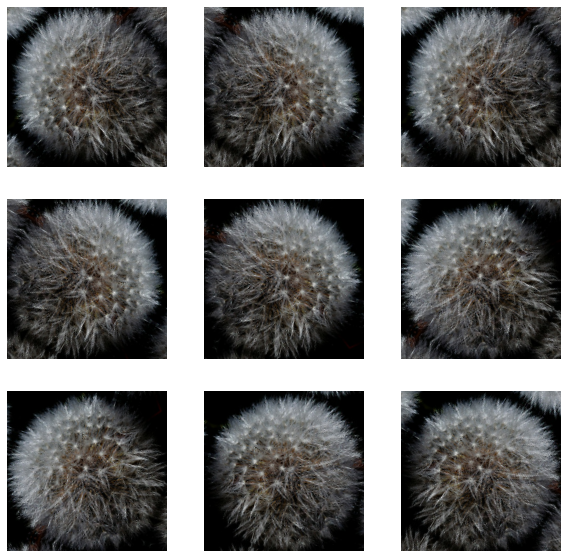

In [ ]:
for image, _ in train_ds.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

## Rescale pixel values

In a moment, you will download tf.keras.applications.MobileNetV2 for use as your base model. This model expects pixel vaues in [-1,1], but at this point, the pixel values in your images are in [0-255]. To rescale them, use the preprocessing method included with the model.

In [ ]:
# normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)


## Build Model

### Create the base model from the pre-trained convnets

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

This feature extractor converts each 160x160x3 image into a 5x5x1280 block of features. Let's see what it does to an example batch of images:

In [ ]:
image_batch, label_batch = next(iter(train_ds))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
base_model.trainable = False


In [ ]:
base_model.summary()


Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 160, 160, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 80, 80, 32)   864         input_2[0][0]                    
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 80, 80, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 80, 80, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

In [ ]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(5)
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 5)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = global_average_layer(x)
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0     

In [ ]:
len(model.trainable_variables)


2

In [ ]:
initial_epochs = 10

loss0, accuracy0 = model.evaluate(val_ds)

23/23 [==============================] - 3s 51ms/step - loss: 2.4646 - accuracy: 0.1770


In [ ]:
print("initial loss: {:.2f}".format(loss0))
print("initial accuracy: {:.2f}".format(accuracy0))

initial loss: 2.47
initial accuracy: 0.17


In [ ]:
history = model.fit(train_ds,
                    epochs=initial_epochs,
                    validation_data=val_ds)

Epoch 1/10
92/92 [==============================] - 11s 88ms/step - loss: 1.8415 - accuracy: 0.2643 - val_loss: 1.4925 - val_accuracy: 0.3597
Epoch 2/10
92/92 [==============================] - 8s 82ms/step - loss: 1.3180 - accuracy: 0.4772 - val_loss: 1.1544 - val_accuracy: 0.5627
Epoch 3/10
92/92 [==============================] - 8s 81ms/step - loss: 1.0625 - accuracy: 0.5879 - val_loss: 0.9574 - val_accuracy: 0.6526
Epoch 4/10
92/92 [==============================] - 8s 81ms/step - loss: 0.8944 - accuracy: 0.6723 - val_loss: 0.8311 - val_accuracy: 0.7112
Epoch 5/10
92/92 [==============================] - 8s 81ms/step - loss: 0.8061 - accuracy: 0.7132 - val_loss: 0.7419 - val_accuracy: 0.7575
Epoch 6/10
92/92 [==============================] - 8s 81ms/step - loss: 0.7173 - accuracy: 0.7401 - val_loss: 0.6768 - val_accuracy: 0.7793
Epoch 7/10
92/92 [==============================] - 8s 81ms/step - loss: 0.6535 - accuracy: 0.7616 - val_loss: 0.6314 - val_accuracy: 0.8052
Epoch 8/10
9

# Evaluation

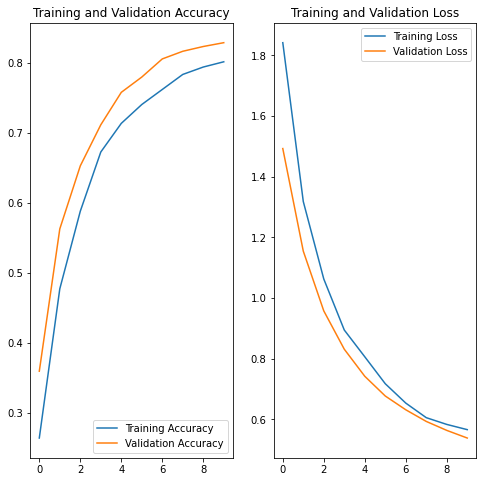

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Fine tuning

In [ ]:
base_model.trainable = True


In [ ]:
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable =  False

Number of layers in the base model:  154


In [ ]:
model.compile(optimizer=tf.keras.optimizers.RMSprop(lr=base_learning_rate/10),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
model.summary()


Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 160, 160, 3)]     0         
_________________________________________________________________
sequential_4 (Sequential)    (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.truediv (TFOpLambda) (None, 160, 160, 3)       0         
_________________________________________________________________
tf.math.subtract (TFOpLambda (None, 160, 160, 3)       0         
_________________________________________________________________
mobilenetv2_1.00_160 (Functi (None, 5, 5, 1280)        2257984   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1280)              0         
_________________________________________________________________
dropout_3 (Dropout)          (None, 1280)              0     

In [ ]:
len(model.trainable_variables)


56

## Continue training the model

In [ ]:
fine_tune_epochs = 10
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_ds,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=val_ds)

Epoch 10/20
92/92 [==============================] - 13s 97ms/step - loss: 0.4778 - accuracy: 0.8074 - val_loss: 0.4087 - val_accuracy: 0.8597
Epoch 11/20
92/92 [==============================] - 9s 88ms/step - loss: 0.3713 - accuracy: 0.8580 - val_loss: 0.3763 - val_accuracy: 0.8678
Epoch 12/20
92/92 [==============================] - 9s 89ms/step - loss: 0.3274 - accuracy: 0.8775 - val_loss: 0.3566 - val_accuracy: 0.8787
Epoch 13/20
92/92 [==============================] - 9s 89ms/step - loss: 0.2837 - accuracy: 0.8931 - val_loss: 0.3276 - val_accuracy: 0.8937
Epoch 14/20
92/92 [==============================] - 8s 88ms/step - loss: 0.2543 - accuracy: 0.8999 - val_loss: 0.3188 - val_accuracy: 0.8965
Epoch 15/20
92/92 [==============================] - 8s 87ms/step - loss: 0.2419 - accuracy: 0.9085 - val_loss: 0.2989 - val_accuracy: 0.9101
Epoch 16/20
92/92 [==============================] - 8s 87ms/step - loss: 0.1987 - accuracy: 0.9304 - val_loss: 0.3069 - val_accuracy: 0.8992
Epoch

In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

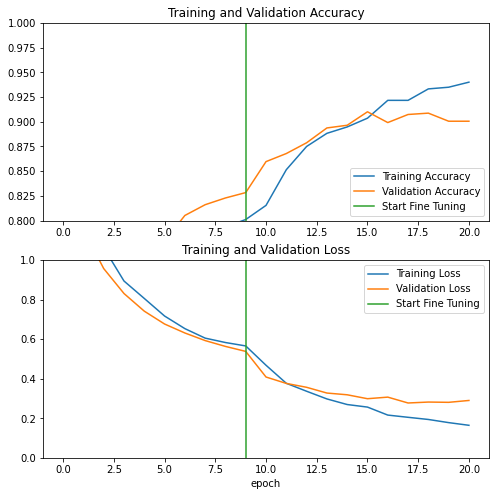

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.8, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(val_ds)
print('Test accuracy :', accuracy)

23/23 [==============================] - 1s 23ms/step - loss: 0.2901 - accuracy: 0.9005
Test accuracy : 0.9005449414253235


Predictions:
 [1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0
 1 0 0 0 0 0 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0
 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 0
 0 0 0 1 0 0 1 0 1 1 1 0 1 0 0 0 0 1 0 1 1 0 0 0 0 0 1 0 1 0 1 0 0 0 0 0 1
 0 1 0 0 0 0 0 0 1 0 0 0]
Labels:
 [0 4 3 0 3 4 1 2 4 0 0 0 4 4 4 3 3 0 0 3 1 4 4 2 3 3 1 2 1 2 4 1]


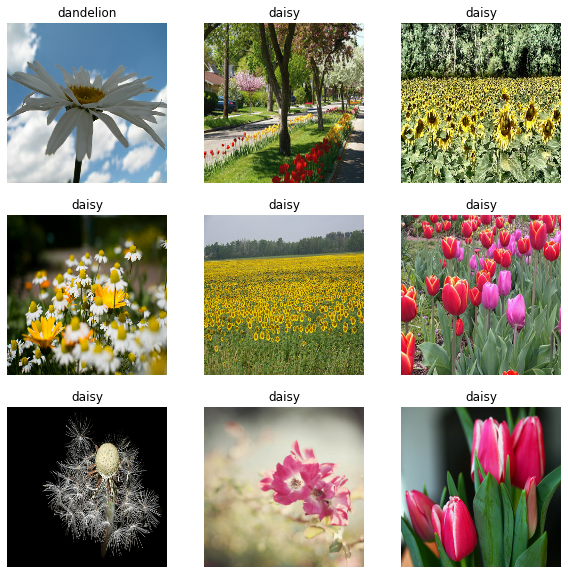

In [ ]:
#Retrieve a batch of images from the test set
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)
 
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(class_names[predictions[i]])
  plt.axis("off")